In [11]:
# importing the necessary libraries
import gym
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

In [12]:
class Network(nn.Module): # defining the DQN architecture
  def __init__(self, state_size, action_size, seed=42): # initializes the Deep Q-network
    super(Network, self).__init__() 
    self.seed=torch.manual_seed(seed) # setting random seed for reproducibility
    self.fc1=nn.Linear(state_size,64) # defining the layers of the neural network
    self.fc2=nn.Linear(64,64)
    self.fc3=nn.Linear(64,action_size)

  def forward(self,state): # performs a forward pass trough the network
    x=self.fc1(state)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    return self.fc3(x)

In [13]:
# initializing the environment
import gymnasium as gym
env=gym.make("LunarLander-v3") # creates the Lunar Lander environment
# getting information from the environment
state_shape=env.observation_space.shape 
state_size=env.observation_space.shape[0]
number_action=env.action_space.n
print('State Shape :',state_shape) 
print('State Size :',state_size)
print('Number of Actions :',number_action)

State Shape : (8,)
State Size : 8
Number of Actions : 4


In [14]:
# defining the hyperparameters for training the agent
learning_rate=5e-4 
minibatch_size=100
discount_factor=0.99
replay_buffer_size=int(1e5)
interpolation_parameter=1e-3

In [15]:
class ReplayMemory(object): # ReplayMemory class for storing experiences
  def __init__(self,capacity): # initializes an experience replay buffer with fixed size
    self.device=torch.device("cpu")
    self.capacity=capacity
    self.memory=[]

  def push(self,event): # adds a new experience to the buffer
    self.memory.append(event)
    if len(self.memory)>self.capacity:
      del self.memory[0]

  def sample(self,batch_size): # takes a batch of experiences from the buffer
    experiences=random.sample(self.memory,k=batch_size) # randomly samples a batch of experiences 
    # coverts those experiences into PyTorch tensors
    states=torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions=torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards=torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states=torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones=torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states,next_states,actions,rewards,dones

In [16]:
#defining the DQN agent
class Agent():
  #local_qnetwork--> selects the action
  #target_qnetwork --> calculate target queue values in the local network
  #double queue network stablizes the learning process
  def __init__(self,state_size,action_size): # initializes the reinforcement learning agent
    self.device=torch.device("cpu")
    self.state_size=state_size
    self.action_size=action_size
    # initializes the local and target Q networks
    self.local_qnetwork=Network(state_size,action_size).to(self.device)
    self.target_qnetwork=Network(state_size,action_size).to(self.device)
    self.optimizer=optim.Adam(self.local_qnetwork.parameters(),lr=learning_rate)
    # initializes the experience replay memory
    self.memory=ReplayMemory(replay_buffer_size)
    self.t_step=0

  def step(self,state,action,reward,next_state,done): # stores experiences in the replay memory and triggers learning
    self.memory.push((state,action,reward,next_state,done))
    self.t_step=(self.t_step + 1) % 4
    if self.t_step==0:
      if len(self.memory.memory)>minibatch_size:
        experiences=self.memory.sample(100)
        self.learn(experiences,discount_factor)

  def act(self,state,epsilon=0.): # selects an action based on the action policy
    state=torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values=self.local_qnetwork(state)
    self.local_qnetwork.train()
    # epsilon-greedy action selection
    if random.random()>epsilon: # chooses the best action (exploitation)
      return np.argmax(action_values.cpu().data.numpy())
    else: # chooses a random action (exploration)
      return random.choice(np.arange(self.action_size))

  def learn(self,experiences,discount_factor): # trains the agent using a batch of experiences from the replay memory
    states,next_states,actions,rewards,dones=experiences
    next_q_targets=self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets=rewards + (discount_factor*next_q_targets*(1-dones))
    q_expected=self.local_qnetwork(states).gather(1,actions)
    loss=F.mse_loss(q_expected,q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork,self.target_qnetwork,interpolation_parameter)

  #soft_update() --> update target_qnetwork parameters by blending them with local_qnetwork (prevent abrupt changes which could destablize the training)
  def soft_update(self,local_model,target_model,interpolation_parameter):
    for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
      target_param.data.copy_(interpolation_parameter*local_param.data+(1.0-interpolation_parameter)*target_param.data)

In [17]:
agent = Agent(state_size,number_action) # initializing the agent and preparing for training

In [18]:
# defining the training parameters
scores_per_episode = []
number_episodes=1300 # total number of episodes 
maximum_number_timesteps_per_episode=1000 # maximum steps per episode
epsilon_starting_value=1.0
epsilon_ending_value=0.01
epsilon_decay_value=0.995
epsilon=epsilon_starting_value
scores_on_100_episodes=deque(maxlen=100) # tracks the average score of the last 100 episodes

# beginning the training loop
for episode in range(1,number_episodes+1):
  state,_=env.reset() # reseting the environment to get the initial state
  score=0 # tracks the total episode score
  # loop that goes trough the episode until the maximum number of steps is reached
  for t in range(maximum_number_timesteps_per_episode):
    action=agent.act(state,epsilon)
    next_state,reward,done,_,_=env.step(action)
    agent.step(state,action,reward,next_state,done)
    state=next_state # update the current state
    score+=reward # accumulating the reward
    if done: # if the episode is finished (crash or landing) exit the loop
      break;
  # store the score of the episode that finished
  scores_on_100_episodes.append(score)
  scores_per_episode.append(score)
  epsilon=max(epsilon_ending_value,epsilon_decay_value*epsilon)
  # prints the episode progress
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)),end="")
  # prints the average score every 100 episodes
  if episode%100==0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)))
  # if the average score over the last 100 episodes is high enough, the training stops
  if np.mean(scores_on_100_episodes)>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode,np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(),'checkpoint.pth')
    break;

Episode 100	Average Score: -152.32
Episode 200	Average Score: -95.555
Episode 300	Average Score: -44.60
Episode 400	Average Score: -29.92
Episode 500	Average Score: 8.5994
Episode 600	Average Score: 65.42
Episode 700	Average Score: 178.39
Episode 769	Average Score: 200.13
Environment solved in 769 episodes!	Average Score: 200.13


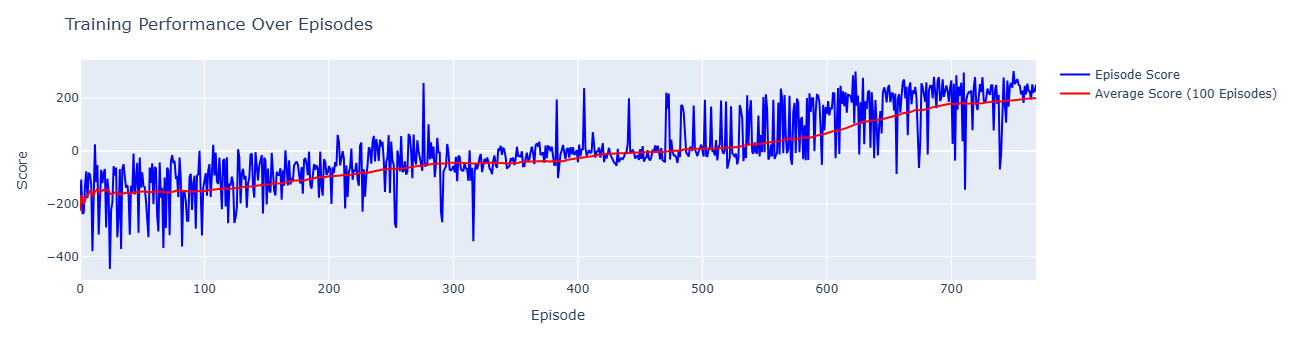

In [19]:
import plotly.express as px
import numpy as np
import pandas as pd

# Compute moving average (ensures first episodes are included)
window_size = 100
average_scores = pd.Series(scores_per_episode).rolling(window=window_size, min_periods=1).mean()

# Create interactive line plot
fig = px.line()

# Plot actual episode scores
fig.add_scatter(x=list(range(len(scores_per_episode))), 
                y=scores_per_episode, 
                mode='lines', 
                name='Episode Score', 
                line=dict(color='blue'))

# Plot moving average scores
fig.add_scatter(x=list(range(len(scores_per_episode))), 
                y=average_scores, 
                mode='lines', 
                name=f'Average Score ({window_size} Episodes)', 
                line=dict(color='red'))

# Labels and title
fig.update_layout(title="Training Performance Over Episodes",
                  xaxis_title="Episode",
                  yaxis_title="Score")

# Show plot
fig.show()

In [20]:
# importing the necessary libraries for rendering the video
import glob
import io
import base64
import imageio
import cv2
import numpy as np
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# function that runs the trained agent in the environment in order to record the video
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frame = cv2.resize(frame, (608, 400), interpolation=cv2.INTER_AREA)
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

# function to display the recorded video
def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video() 